In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import geopandas as gpd
import seaborn as sns

#Packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from scipy import stats
pd.set_option('display.max_columns', None)

from scipy.stats import skew, kurtosis

import pygris
from shapely.geometry import Polygon

import shapely

In [3]:
# Read the parquet file
df_read = pd.read_parquet("C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/lat_long_geometry.parquet.gzip")

# Convert the WKT strings back to geometries
lat_long_df = gpd.GeoDataFrame(df_read, geometry=df_read['geometry'].apply(lambda x: shapely.wkt.loads(x)))

In [7]:
chunk_size = 25000  # adjust based on your system's capabilities
chunks = [x for x in range(0, 400000, chunk_size)]

gdf_list = []

for start in chunks:
    end = start + chunk_size
    temp_df = pd.read_parquet(f"C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/BG_geometry_{start}_{end}.parquet.gzip")
    gdf_read = gpd.GeoDataFrame(temp_df, geometry=temp_df['geometry'].apply(lambda x: shapely.wkt.loads(x)))
    gdf_list.append(gdf_read)

# Concatenate all GeoDataFrames in the list into a single GeoDataFrame
BG_df = pd.concat(gdf_list, ignore_index=True)

In [8]:
chunk_size = 25000  # adjust based on your system's capabilities
chunks = [x for x in range(0, 100000, chunk_size)]

gdf_list = []

for start in chunks:
    end = start + chunk_size
    temp_df = pd.read_parquet(f"C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/zipcode_geometry_{start}_{end}.parquet.gzip")
    gdf_read = gpd.GeoDataFrame(temp_df, geometry=temp_df['geometry'].apply(lambda x: shapely.wkt.loads(x)))
    gdf_list.append(gdf_read)
    
# Concatenate all GeoDataFrames in the list into a single GeoDataFrame
zipcode_df = pd.concat(gdf_list, ignore_index=True)

In [9]:
print(zipcode_df.shape[0])
print(BG_df.shape[0])

90165
386324


In [10]:
zipcode_df = zipcode_df.drop_duplicates(subset=['ZIPcode', 'year'])
BG_df = BG_df.drop_duplicates(subset=['GEOID', 'year'])

In [13]:
print(zipcode_df.shape[0])
print(BG_df.shape[0])
print(lat_long_df.shape[0])

90165
386239
25127


In [17]:
BG_df_yearwise = {}

# Iterate through unique years and create separate DataFrames
for year in BG_df['year'].unique():
    BG_df_yearwise[year] = BG_df[BG_df['year'] == year].copy()

BG_df_2021 = BG_df_yearwise[2021]
BG_df_2012 = BG_df_yearwise[2012]
BG_df_2010 = BG_df_yearwise[2010]
BG_df_2000 = BG_df_yearwise[2000]
BG_df_1990 = BG_df_yearwise[1990]

In [29]:
import geopandas as gpd
from shapely.geometry import Polygon
from itertools import product
import warnings
warnings.filterwarnings("ignore")

In [42]:
# Create an empty GeoDataFrame to store the intersection results
new_unit_df_2021 = gpd.GeoDataFrame(columns=['geographic_unit_id', 'BG_id', 'latitude', 'longitude', 'geometry', 'year'])

# Iterate through each row in BG_df_2021 and each row in lat_long_df to find intersections
for idx_bg, row_bg in BG_df_2021.iterrows():
    year = row_bg['year']
    bg_id = row_bg['GEOID']
    bg_geometry = row_bg['geometry']
    
    for idx_lat_long, row_lat_long in lat_long_df.iterrows():
        
        lat_long_geometry = row_lat_long['geometry']
        lat = row_lat_long['latitude']
        long = row_lat_long['longitude']
        # Compute intersection geometry

        intersection_geometry = bg_geometry.intersection(lat_long_geometry)
            
        # Check if the intersection result is valid
        if not intersection_geometry.is_empty:
            # Create a unique ID for the intersection using the year and indices
            geographic_unit_id = f"{year}_{bg_id}_{lat}_{long}"

            # Append intersection information to a list
            new_unit_df_2021 = pd.concat([new_unit_df_2021, pd.DataFrame({
                'geographic_unit_id': [geographic_unit_id],
                'BG_id': [bg_id],
                'latitude': [lat],
                'longitude': [long],
                'geometry': [intersection_geometry],
                'year': [year]
            })], ignore_index=True)

In [43]:
# Create an empty GeoDataFrame to store the intersection results
new_unit_df_2012 = gpd.GeoDataFrame(columns=['geographic_unit_id', 'BG_id', 'latitude', 'longitude', 'geometry', 'year'])

# Iterate through each row in BG_df_2012 and each row in lat_long_df to find intersections
for idx_bg, row_bg in BG_df_2012.iterrows():
    year = row_bg['year']
    bg_id = row_bg['GEOID']
    bg_geometry = row_bg['geometry']
    
    for idx_lat_long, row_lat_long in lat_long_df.iterrows():
        
        lat_long_geometry = row_lat_long['geometry']
        lat = row_lat_long['latitude']
        long = row_lat_long['longitude']
        # Compute intersection geometry

        intersection_geometry = bg_geometry.intersection(lat_long_geometry)
            
        # Check if the intersection result is valid
        if not intersection_geometry.is_empty:
            # Create a unique ID for the intersection using the year and indices
            geographic_unit_id = f"{year}_{bg_id}_{lat}_{long}"

            # Append intersection information to a list
            new_unit_df_2012 = pd.concat([new_unit_df_2012, pd.DataFrame({
                'geographic_unit_id': [geographic_unit_id],
                'BG_id': [bg_id],
                'latitude': [lat],
                'longitude': [long],
                'geometry': [intersection_geometry],
                'year': [year]
            })], ignore_index=True)

,geographic_unit_id,BG_id,latitude,longitude,geometry
0,2021_010030114121_30.3_-87.7,010030114121,30.3,-87.7,"POLYGON ((-87.74999 30.29132, -87.74964 30.292..."
1,2021_010030114182_30.3_-87.6,010030114182,30.3,-87.6,"POLYGON ((-87.64990 30.26746, -87.64948 30.266..."
2,2021_010030114182_30.3_-87.7,010030114182,30.3,-87.7,"POLYGON ((-87.68949 30.25035, -87.68947 30.250..."
3,2021_010030114182_30.2_-87.7,010030114182,30.2,-87.7,"POLYGON ((-87.69136 30.24822, -87.69058 30.248..."
4,2021_010030114151_30.3_-87.6,010030114151,30.3,-87.6,"POLYGON ((-87.58050 30.26948, -87.58059 30.270..."


In [ ]:
# Create an empty GeoDataFrame to store the intersection results
new_unit_df_2010 = gpd.GeoDataFrame(columns=['geographic_unit_id', 'BG_id', 'latitude', 'longitude', 'geometry', 'year'])

# Iterate through each row in BG_df_2010 and each row in lat_long_df to find intersections
for idx_bg, row_bg in BG_df_2010.iterrows():
    year = row_bg['year']
    bg_id = row_bg['GEOID']
    bg_geometry = row_bg['geometry']
    
    for idx_lat_long, row_lat_long in lat_long_df.iterrows():
        
        lat_long_geometry = row_lat_long['geometry']
        lat = row_lat_long['latitude']
        long = row_lat_long['longitude']
        # Compute intersection geometry

        intersection_geometry = bg_geometry.intersection(lat_long_geometry)
            
        # Check if the intersection result is valid
        if not intersection_geometry.is_empty:
            # Create a unique ID for the intersection using the year and indices
            geographic_unit_id = f"{year}_{bg_id}_{lat}_{long}"

            # Append intersection information to a list
            new_unit_df_2010 = pd.concat([new_unit_df_2010, pd.DataFrame({
                'geographic_unit_id': [geographic_unit_id],
                'BG_id': [bg_id],
                'latitude': [lat],
                'longitude': [long],
                'geometry': [intersection_geometry],
                'year': [year]
            })], ignore_index=True)

In [ ]:
# Create an empty GeoDataFrame to store the intersection results
new_unit_df_2000 = gpd.GeoDataFrame(columns=['geographic_unit_id', 'BG_id', 'latitude', 'longitude', 'geometry', 'year'])

# Iterate through each row in BG_df_2000 and each row in lat_long_df to find intersections
for idx_bg, row_bg in BG_df_2000.iterrows():
    year = row_bg['year']
    bg_id = row_bg['GEOID']
    bg_geometry = row_bg['geometry']
    
    for idx_lat_long, row_lat_long in lat_long_df.iterrows():
        
        lat_long_geometry = row_lat_long['geometry']
        lat = row_lat_long['latitude']
        long = row_lat_long['longitude']
        # Compute intersection geometry

        intersection_geometry = bg_geometry.intersection(lat_long_geometry)
            
        # Check if the intersection result is valid
        if not intersection_geometry.is_empty:
            # Create a unique ID for the intersection using the year and indices
            geographic_unit_id = f"{year}_{bg_id}_{lat}_{long}"

            # Append intersection information to a list
            new_unit_df_2000 = pd.concat([new_unit_df_2000, pd.DataFrame({
                'geographic_unit_id': [geographic_unit_id],
                'BG_id': [bg_id],
                'latitude': [lat],
                'longitude': [long],
                'geometry': [intersection_geometry],
                'year': [year]
            })], ignore_index=True)

In [ ]:
# Create an empty GeoDataFrame to store the intersection results
new_unit_df_1990 = gpd.GeoDataFrame(columns=['geographic_unit_id', 'BG_id', 'latitude', 'longitude', 'geometry', 'year'])

# Iterate through each row in BG_df_1990 and each row in lat_long_df to find intersections
for idx_bg, row_bg in BG_df_1990.iterrows():
    year = row_bg['year']
    bg_id = row_bg['GEOID']
    bg_geometry = row_bg['geometry']
    
    for idx_lat_long, row_lat_long in lat_long_df.iterrows():
        
        lat_long_geometry = row_lat_long['geometry']
        lat = row_lat_long['latitude']
        long = row_lat_long['longitude']
        # Compute intersection geometry

        intersection_geometry = bg_geometry.intersection(lat_long_geometry)
            
        # Check if the intersection result is valid
        if not intersection_geometry.is_empty:
            # Create a unique ID for the intersection using the year and indices
            geographic_unit_id = f"{year}_{bg_id}_{lat}_{long}"

            # Append intersection information to a list
            new_unit_df_1990 = pd.concat([new_unit_df_1990, pd.DataFrame({
                'geographic_unit_id': [geographic_unit_id],
                'BG_id': [bg_id],
                'latitude': [lat],
                'longitude': [long],
                'geometry': [intersection_geometry],
                'year': [year]
            })], ignore_index=True)

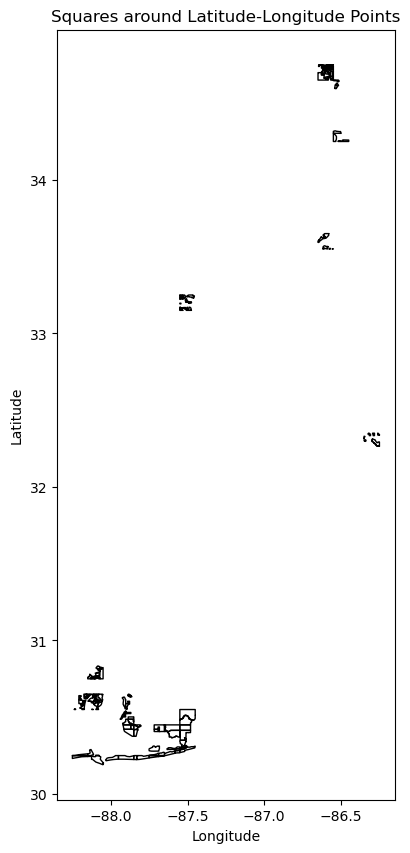

In [44]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(new_unit_df_2021, geometry='geometry')

gdf.plot(edgecolor="black", facecolor="none", figsize=(10, 10))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Squares around Latitude-Longitude Points')

plt.show()